# Introduction
You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

* stores.csv

This file contains anonymized information about the 45 stores, indicating the type and size of store.

* train.csv

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

* Store - the store number
* Dept - the department number
* Date - the week
* Weekly_Sales -  sales for the given department in the given store
* IsHoliday - whether the week is a special holiday week

--

* test.csv

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

* features.csv

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

* Store - the store number
* Date - the week
* Temperature - average temperature in the region
* Fuel_Price - cost of fuel in the region
* MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
* CPI - the consumer price index
* Unemployment - the unemployment rate
* IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [14]:
import pandas as pn
import numpy as np
import array as arrr
import category_encoders as ce
import statistics
import warnings
warnings.filterwarnings('ignore')


from IPython.display import display

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from scipy.stats import boxcox


from matplotlib import pyplot as plt
import seaborn as sns

import pydotplus
import io
import math
import seaborn as sns
import graphviz
from scipy import misc
import imageio
%matplotlib inline

In [15]:
%%html
<h1> Reading <span style="color:blue">Train</span> and <span style="color:green">Test</span> Data </h1>

In [29]:
features = pn.read_csv('features.csv', delimiter=",")
stores = pn.read_csv('stores.csv', delimiter=",")
trainData = pn.read_csv("train.csv", delimiter=",")
testData = pn.read_csv("test.csv", delimiter=",")
sampleSubmission = pn.read_csv('sampleSubmission.csv', delimiter=',')


In [4]:
# sampleSubmission

In [4]:
features.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')

In [5]:
stores.columns

Index(['Store', 'Type', 'Size'], dtype='object')

In [18]:
trainData.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [5]:
# features

In [6]:
# stores

In [12]:
%%html
<h2 style='color:blue'> Data Analysis & Visualization</h2>Visualization

In [7]:
trainData.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [8]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


Text(0.5, 1.0, 'Weekly Sales in Holidays Weeks')

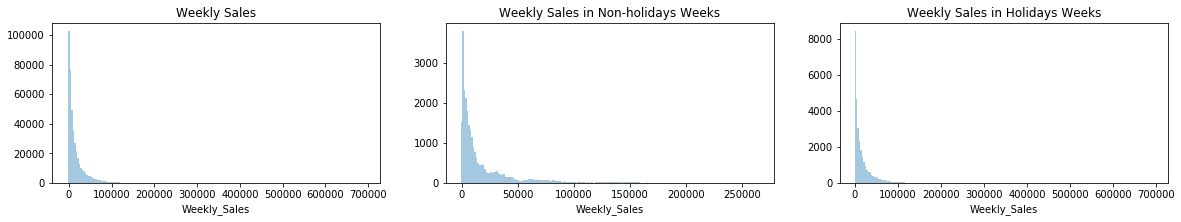

In [17]:
plt.figure(figsize=(20, 10))

plt.subplot(3,3,1)
sns.distplot(trainData['Weekly_Sales'], kde=False, bins=200)
plt.title('Weekly Sales')

plt.subplot(3,3,2)
sns.distplot(trainData.loc[: 29661]['Weekly_Sales'][trainData['IsHoliday'] == False], kde=False, bins=200)
plt.title('Weekly Sales in Non-holidays Weeks')

plt.subplot(3,3,3)
sns.distplot(trainData['Weekly_Sales'][trainData['IsHoliday'] == True], kde=False, bins=200)
plt.title('Weekly Sales in Holidays Weeks')
# trainData[trainData['IsHoliday'] == True]
# trainData.loc[: 30661]['Weekly_Sales'][trainData['IsHoliday'] == False]

In [76]:
trainData['Weekly_Sales'][trainData['Weekly_Sales'] < -1000].count()

9

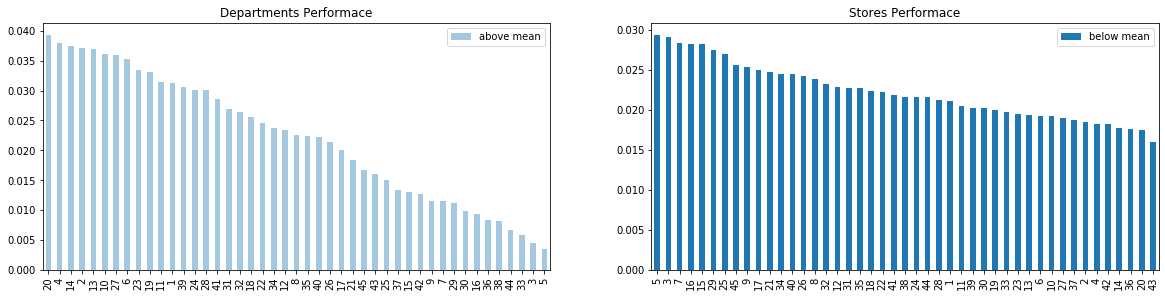

In [18]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
trainData.Store[trainData['Weekly_Sales'] > trainData['Weekly_Sales'].mean()].value_counts(normalize=True).plot(kind="bar", alpha=0.4, label="above mean")
plt.title('Departments Performace')
plt.legend()

plt.subplot(2, 2, 2)
trainData.Store[trainData['Weekly_Sales'] < trainData['Weekly_Sales'].mean()].value_counts(normalize=True).plot(kind="bar", alpha=1, label="below mean")
plt.title('Stores Performace')
plt.legend()

In [30]:
trainData = trainData.merge(stores, how='left', left_on=['Store'], right_on=['Store'])
testData = testData.merge(stores, how='left', left_on=['Store'], right_on=['Store'])
trainData

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315
5,1,1,2010-03-12,21043.39,False,A,151315
6,1,1,2010-03-19,22136.64,False,A,151315
7,1,1,2010-03-26,26229.21,False,A,151315
8,1,1,2010-04-02,57258.43,False,A,151315
9,1,1,2010-04-09,42960.91,False,A,151315


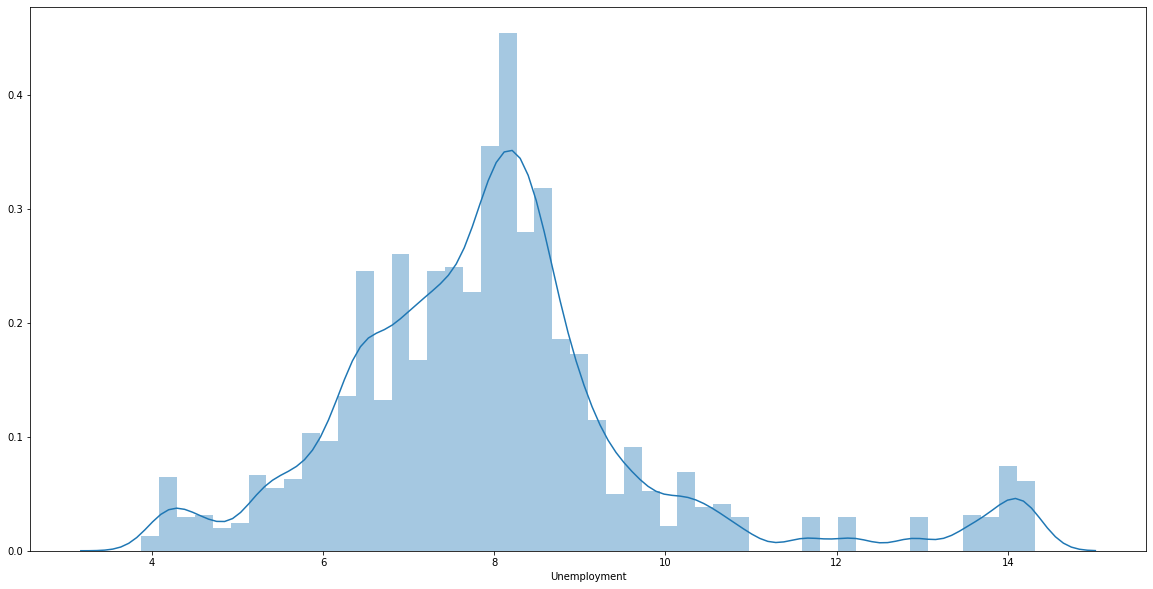

In [28]:
top_departments = [95, 38, 92, 40, 2]
plt.figure(figsize=(20, 10))
sns.distplot(trainData.Unemployment[(trainData['Dept'] == 95) & (trainData.Weekly_Sales > trainData.Weekly_Sales.mean())])

In [24]:
temp = pn.DataFrame()
temp = trainData[(trainData['Dept'] == 1) & (trainData['Store'] == 1)]

for i in trainData['Store'].unique():
    if(i == 1):
        continue
    temp = temp.append(trainData[(trainData['Dept'] == 1) & (trainData['Store'] == i)])
    
temp

train_features = temp.drop(['Dept'], axis="columns").merge(features.drop(['IsHoliday'], axis="columns"), how="left", left_on=['Store', 'Date'], right_on=['Store', 'Date'])
train_features

,Store,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
5,1,2010-03-12,21043.39,False,A,151315,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106
6,1,2010-03-19,22136.64,False,A,151315,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106
7,1,2010-03-26,26229.21,False,A,151315,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106
8,1,2010-04-02,57258.43,False,A,151315,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808
9,1,2010-04-09,42960.91,False,A,151315,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808


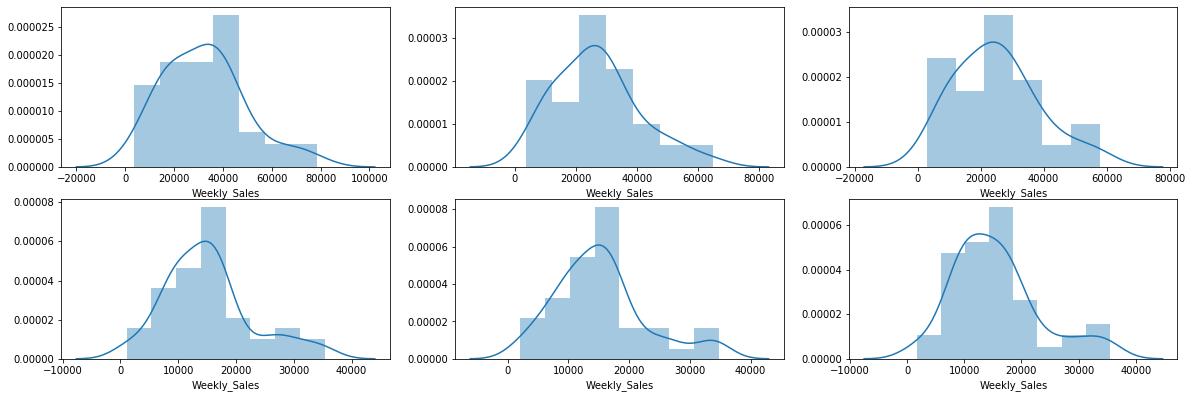

In [25]:
super_bowl = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']
labor_day = ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'] 
thanksgiving = ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'] 
christmas = ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']

plt.figure(figsize=(20, 10))

plt.subplot(3,3,1)
sns.distplot(train_features.Weekly_Sales[train_features.Date == super_bowl[0]])
# plt.title('Weekly Sales')

plt.subplot(3,3,2)
sns.distplot(train_features.Weekly_Sales[train_features.Date == super_bowl[1]])
# plt.title('Weekly Sales in Hildays Weeks')

plt.subplot(3,3,3)
sns.distplot(train_features.Weekly_Sales[train_features.Date == super_bowl[2]])
# plt.title('Weekly Sales in Non-holiday Weeks')

plt.subplot(3,3,4)
sns.distplot(train_features.Weekly_Sales[train_features.Date == labor_day[0]])
# plt.title('Weekly Sales')

plt.subplot(3,3,5)
sns.distplot(train_features.Weekly_Sales[train_features.Date == labor_day[1]])
# plt.title('Weekly Sales in Hildays Weeks')

plt.subplot(3,3,6)
sns.distplot(train_features.Weekly_Sales[train_features.Date == labor_day[2]])
# plt.title('Weekly Sales in Non-holiday Weeks')

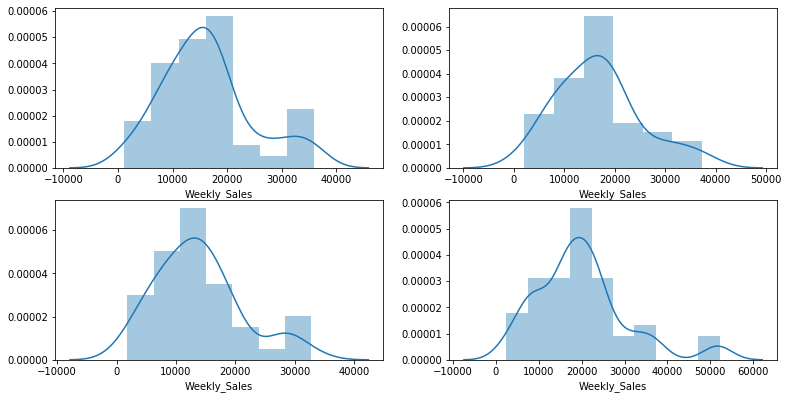

In [26]:
plt.figure(figsize=(20, 10))

plt.subplot(3,3,1)
sns.distplot(train_features.Weekly_Sales[train_features.Date == thanksgiving[0]])
# plt.title('Weekly Sales')

plt.subplot(3,3,2)
sns.distplot(train_features.Weekly_Sales[train_features.Date == thanksgiving[1]])
# plt.title('Weekly Sales in Hildays Weeks')


plt.subplot(3,3,4)
sns.distplot(train_features.Weekly_Sales[train_features.Date == christmas[0]])
# plt.title('Weekly Sales')

plt.subplot(3,3,5)
sns.distplot(train_features.Weekly_Sales[train_features.Date == christmas[1]])
# plt.title('Weekly Sales in Hildays Weeks')


In [27]:
# features = features.drop(['IsHoliday'], axis='columns')
# train_features = trainData.merge(features, how='right', left_on=['Date', 'Store'], right_on=['Date', 'Store'])
# trainData = trainData.merge(features, how='left', left_on=['Date', 'Store'], right_on=['Date', 'Store'])
# testData = testData.merge(features, how='left', left_on=['Date', 'Store'], right_on=['Date', 'Store'])
# trainData = trainData.dropna()

In [31]:
# train_features[(train_features['Dept'] == 20.0) & (train_features['Store'] == 45)]
# train_features
# testData['MarkDown1'] = testData['MarkDown2'].fillna(0)
# testData['MarkDown2'] = testData['MarkDown2'].fillna(0)
# testData['MarkDown3'] = testData['MarkDown3'].fillna(0)
# testData['MarkDown4'] = testData['MarkDown4'].fillna(0)
# testData['MarkDown5'] = testData['MarkDown5'].fillna(0)
# testData['CPI'] = testData['CPI'].fillna(0)
# testData['Unemployment'] = testData['Unemployment'].fillna(0)
# testData

# Data Preprocessing
In this following techniques will be used to preprcess and clean the data to build train and test data for classifier that will forecast the sales:


In [32]:
trainData = trainData.drop(['Date'], axis='columns')
testData = testData.drop(['Date'], axis='columns')

In [33]:

for i in trainData.columns:
    if(i == "Weekly_Sales"):
        continue
    if(type(trainData.loc[trainData.index[0], i]) == str):
        trainData[i] = LabelEncoder().fit_transform(trainData[i])
        
for i in trainData.columns:  
    if(type(trainData.loc[trainData.index[0], i]) != str and i != "Weekly_Sales"):
        trainData.loc[:, i] = (trainData[i] - trainData[i].mean())/(max(trainData[i]) - min(trainData[i]))

    
for i in testData.columns:
    if(type(testData.loc[testData.index[0], i]) == str):
        testData[i] = LabelEncoder().fit_transform(testData[i])
        
for i in testData.columns:  
    if(type(testData.loc[testData.index[0], i]) != str and i != "Weekly_Sales"):
        testData.loc[:, i] = (testData[i] - testData[i].mean())/(max(testData[i]) - min(testData[i]))

    
        
trainData

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size
0,-0.481831,-0.441432,24924.50,-0.070358,-0.294956,0.078957
1,-0.481831,-0.441432,46039.49,0.929642,-0.294956,0.078957
2,-0.481831,-0.441432,41595.55,-0.070358,-0.294956,0.078957
3,-0.481831,-0.441432,19403.54,-0.070358,-0.294956,0.078957
4,-0.481831,-0.441432,21827.90,-0.070358,-0.294956,0.078957
5,-0.481831,-0.441432,21043.39,-0.070358,-0.294956,0.078957
6,-0.481831,-0.441432,22136.64,-0.070358,-0.294956,0.078957
7,-0.481831,-0.441432,26229.21,-0.070358,-0.294956,0.078957
8,-0.481831,-0.441432,57258.43,-0.070358,-0.294956,0.078957
9,-0.481831,-0.441432,42960.91,-0.070358,-0.294956,0.078957


In [34]:
from sklearn.ensemble import GradientBoostingRegressor

regr = GradientBoostingRegressor(learning_rate=0.01, n_estimators=5000)

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

seed = 7
kfold = model_selection.KFold(n_splits=3, random_state=seed)
scoring = 'neg_mean_absolute_error'

X = trainData.drop(['Weekly_Sales'], axis='columns')
Y = trainData.Weekly_Sales

results = model_selection.cross_val_score(regr, X, Y, cv=kfold, scoring=scoring)
print("Mean Absolute Error: ", round(abs(results.mean())))

Mean Absolute Error:  7118.0


In [190]:
y = regr.predict(testData)
prediction = { 'Id' : sampleSubmission['Id'],
              'Weekly_Sales': y
}        
y

array([24319.65013448, 24319.65013448, 24319.65013448, ...,
        2911.23140078,  2911.23140078,  2911.23140078])

In [191]:
predictions = pn.DataFrame(prediction, columns=['Id', 'Weekly_Sales']).to_csv('result5.csv', index=False)